<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/experiments/morse_fitting/dft_morse_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade dftbook
!pip install mendeleev
!pip install joblib
import dftbook
dftbook.setup_colab()

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 870kB 8.6MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.0-py2.py3-none-any.whl size=174815 sha256=ce8736cce3ef592ed1f6877e8afde09e6e035dcc7a28133f162273f4d9a98d87
  Stored in directory: /root/.cache/pip/wheels/d0/cc/31/f29de1f18ba448de24744c059b03fa665f5db4eecadfd2d3a7
Successfully built mendeleev
Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 25.4 seconds


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
from ase import Atoms, Atom
import numpy as np
import pandas as pd
import pickle
import time
from espresso import Espresso
from joblib import Memory
from ase.calculators.morse import MorsePotential
from ase.calculators.emt import EMT
from ase.optimize import QuasiNewton
from ase.vibrations import Vibrations
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mendeleev import element

memory = Memory('./', verbose=0)

@memory.cache
def get_pair_energy(element_symbol, dist):

  # Set up the atoms object at a fixed distance
  atoms = Atoms([Atom(element_symbol,position=[0,0,0]),
                 Atom(element_symbol, position=[0,0,dist])])
  atoms.set_cell([10, 10, 10])
  atoms.center()
  
  # Make the calculator
  calc = Espresso(pw=500.0,
                  calculation='scf',
                  xc='PBE')
  atoms.set_calculator(calc)

  #Return the single-point energy
  energy = atoms.get_potential_energy()
  return energy

@memory.cache
def relax_atoms(element_symbol, covalent_distance):

  #Make the atoms object at a good guess distance using the covalent radius
  atoms = Atoms([Atom(element_symbol,position=[0,0,0]),
                 Atom(element_symbol, position=[0,0,covalent_distance*2])])
  atoms.set_cell([10, 10, 10])
  atoms.center()

  #Set up the calculator
  calc = Espresso(pw=500.0,
                  calculation='scf',
                  xc='PBE')
  atoms.set_calculator(calc)

  #Run the relaxation
  dyn = QuasiNewton(atoms)
  dyn.run(fmax=0.01, steps=5)

  return atoms

@memory.cache
def get_lone_energy(element_symbol):
  atoms = Atoms([Atom(element_symbol,position=[0,0,0])])
  atoms.set_cell([10, 10, 10])
  atoms.center()
  calc = Espresso(pw=500.0,
                  calculation='scf',
                  xc='PBE')
  atoms.set_calculator(calc)

  energy = atoms.get_potential_energy()
  return energy

def morse_potential(r, De, re, a):
  # calculate the morse potential energy
  return De*(np.exp(-2*a*(r-re))-2*np.exp(-a*(r-re)))

def bond_calcs(element_number):
  
  #Get element info from mendeleev
  elem = element(element_number)
  covalent_radius=elem.covalent_radius/100

  # Get the equilibrium bond distance/energy
  lone_energy = get_lone_energy(elem.symbol)
  relaxed_atoms = relax_atoms(elem.symbol, covalent_radius)

  #Calculate the first two morse parameters from the ground state
  De = -(relaxed_atoms.get_potential_energy()-2*lone_energy)
  re = relaxed_atoms.get_distance(0,1)

  #Select points around the equilibrium radius to sample
  distances = np.array([0.7, 0.8, 0.9, 1.1, 1.2])*re

  # Stretch the bond and fit the last parameter
  stretched_energies = np.array([get_pair_energy(elem.symbol, dist)-2*lone_energy
                        for dist in distances])
  if De<0:
    De=1e-1
    stretched_energies=stretched_energies \
                        -(relaxed_atoms.get_potential_energy()-2*lone_energy) \
                        -De
  popt, pcov = curve_fit(lambda x, sig: morse_potential(x, De, re, sig),
                       distances,
                       stretched_energies,
                       p0=(2))
  sig = popt[0]

  # Plot the morse potential fit
  img_dict = {'De': [De], 're': [re], 'sig': [sig]}
  df = pd.DataFrame(img_dict)
  df.to_csv(f'./morse_params/{elem.symbol}{elem.symbol}.csv', index=None)
  all_distances = np.linspace(0.6,1.5)*re
  plt.figure(figsize=(10,10))
  plt.plot(distances,stretched_energies,'o',label='DFT')
  plt.plot(all_distances, morse_potential(all_distances, De, re, sig), label='Morse Fit')
  plt.legend()
  plt.xlabel('Pair-Wise Distances [Angstroms]', fontsize=32)
  plt.ylabel('Energy [eV]', fontsize=32)
  plt.tick_params(labelsize=28)
  plt.title('%s-%s'%(elem.symbol,elem.symbol), fontsize=32)
  plt.savefig('%s-%s.png'%(elem.symbol,elem.symbol))
  plt.show()
  

  return elem, distances, stretched_energies, all_distances, morse_potential(all_distances, De, re, sig)



In [ ]:
! rm -rf qe_* *.png *.pdf
os.mkdir("morse_params")

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:10:08   -10982.659391*       0.1579
BFGSLineSearch:    1[  2] 19:11:00   -10982.661256*       0.0166
BFGSLineSearch:    2[  3] 19:11:29   -10982.661266*       0.0010


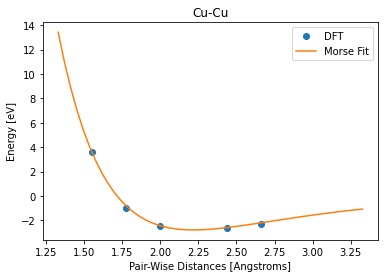

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:11:39   -12556.946858*       1.6092
BFGSLineSearch:    1[  1] 19:11:49   -12557.234323*       0.4248
BFGSLineSearch:    2[  3] 19:12:09   -12557.303454*       0.0300
BFGSLineSearch:    3[ 70] 19:21:03   -12557.303786*       0.0167
BFGSLineSearch:    4[ 79] 19:22:27   -12557.303786*       0.0167
BFGSLineSearch:    5[131] 19:28:32   -12557.303786*       0.0168


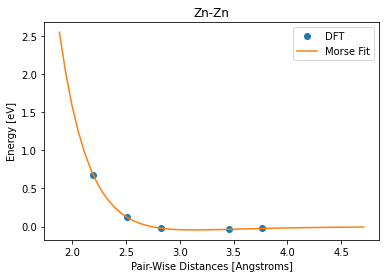

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:30:09   -11298.120201*       0.5939
BFGSLineSearch:    1[  1] 19:30:29   -11298.170049*       0.2484
BFGSLineSearch:    2[  2] 19:30:50   -11298.184655*       0.1052
BFGSLineSearch:    3[  3] 19:31:12   -11298.186999*       0.0129
BFGSLineSearch:    4[  7] 19:32:37   -11298.187041*       0.0027


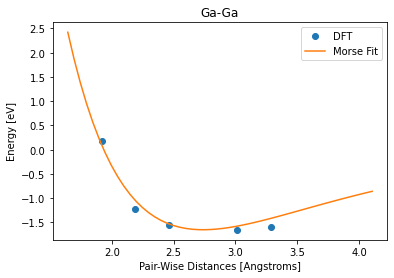

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:34:43    -5809.204935*       0.3202
BFGSLineSearch:    1[  1] 19:34:54    -5809.211925*       0.1186
BFGSLineSearch:    2[  2] 19:35:05    -5809.213066*       0.0156
BFGSLineSearch:    3[ 26] 19:38:39    -5809.213066*       0.0127
BFGSLineSearch:    4[ 62] 19:44:09    -5809.213066*       0.0124
BFGSLineSearch:    5[120] 19:52:45    -5809.213066*       0.0116


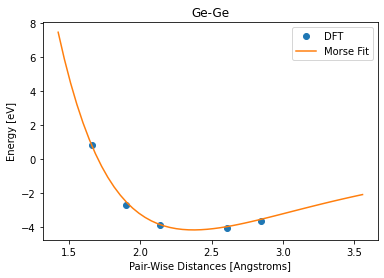

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:54:00    -1093.354197*       4.1422
BFGSLineSearch:    1[  2] 19:54:20    -1094.060706*       1.6187
BFGSLineSearch:    2[  4] 19:54:41    -1094.123508*       0.0521
BFGSLineSearch:    3[  5] 19:54:51    -1094.123557*       0.0088


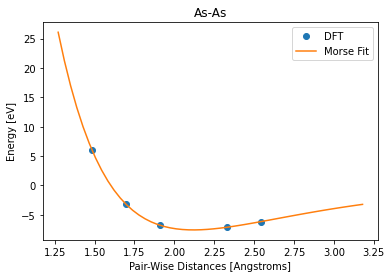

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:55:59    -1184.909268*       1.9376
BFGSLineSearch:    1[  2] 19:56:18    -1185.039200*       0.2954
BFGSLineSearch:    2[  3] 19:56:27    -1185.041218*       0.0968
BFGSLineSearch:    3[  4] 19:56:37    -1185.041444*       0.0028


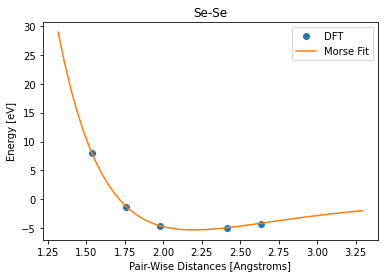

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:57:45    -1274.468718*       0.4897
BFGSLineSearch:    1[  2] 19:58:05    -1274.476250*       0.0009


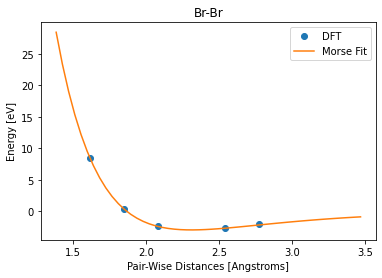

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 19:59:20    -1445.921006*       0.2245
BFGSLineSearch:    1[  3] 19:59:56    -1445.994561*       0.0378
BFGSLineSearch:    2[  4] 20:00:08    -1445.997363*       0.0081


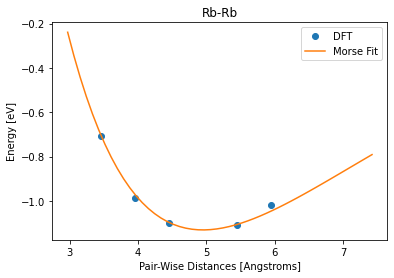

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:01:31    -1905.196510*       0.7609
BFGSLineSearch:    1[  2] 20:01:56    -1905.423299*       0.1533
BFGSLineSearch:    2[  4] 20:02:19    -1905.450075*       0.0314
BFGSLineSearch:    3[  6] 20:02:42    -1905.454422*       0.0057


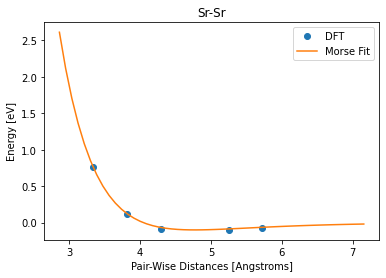

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:04:08    -2518.368736*       0.5431
BFGSLineSearch:    1[  2] 20:04:40    -2518.599647*       0.1701
BFGSLineSearch:    2[  4] 20:05:11    -2518.604559*       0.0164
BFGSLineSearch:    3[  5] 20:05:28    -2518.604608*       0.0036


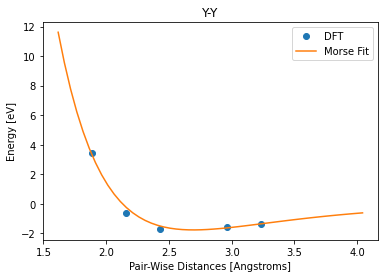

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:07:14    -2687.268927*       2.8629
BFGSLineSearch:    1[  2] 20:07:44    -2689.533984*       0.3181
BFGSLineSearch:    2[  4] 20:08:14    -2689.536885*       0.0117
BFGSLineSearch:    3[  5] 20:08:28    -2689.536888*       0.0003


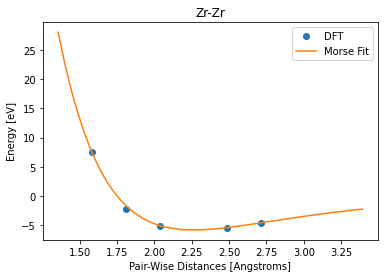

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:10:28    -3195.528267*       5.0229
BFGSLineSearch:    1[  2] 20:10:52    -3199.806168*       2.0971
BFGSLineSearch:    2[  4] 20:11:22    -3199.887906*       0.1895
BFGSLineSearch:    3[  5] 20:11:35    -3199.888520*       0.0104
BFGSLineSearch:    4[  6] 20:11:48    -3199.888522*       0.0000


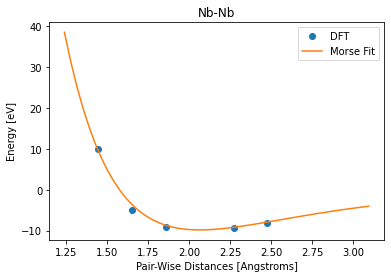

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:13:47    -3777.289876*       6.6224
BFGSLineSearch:    1[  2] 20:14:15    -3782.981102*       2.0623
BFGSLineSearch:    2[  4] 20:14:42    -3783.024969*       0.0428
BFGSLineSearch:    3[  5] 20:14:54    -3783.024987*       0.0051


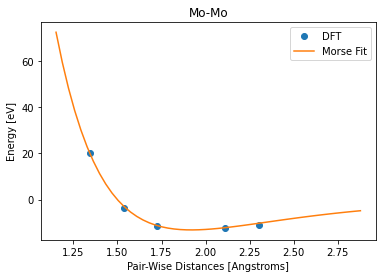

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:17:02    -4729.423878*       6.7313
BFGSLineSearch:    1[  3] 20:17:50    -4733.036499*       0.9580
BFGSLineSearch:    2[  5] 20:18:20    -4733.046511*       0.0496
BFGSLineSearch:    3[  6] 20:18:35    -4733.046535*       0.0026


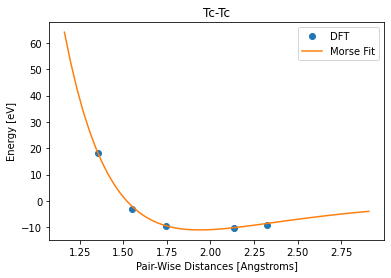

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:20:55    -5274.152263*       4.7923
BFGSLineSearch:    1[  3] 20:21:49    -5276.099362*       0.4589
BFGSLineSearch:    2[  5] 20:22:28    -5276.102634*       0.0135
BFGSLineSearch:    3[  6] 20:22:46    -5276.102637*       0.0006


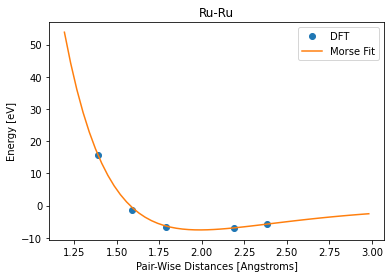

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:25:23    -4649.241015*       2.2025
BFGSLineSearch:    1[  3] 20:26:17    -4649.706015*       0.0008


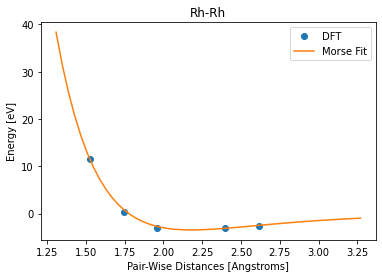

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:28:23    -5400.729236*       0.8551
BFGSLineSearch:    1[  1] 20:28:54    -5400.766038*       0.2764
BFGSLineSearch:    2[  2] 20:29:25    -5400.773549*       0.0763
BFGSLineSearch:    3[  3] 20:29:55    -5400.774089*       0.0111
BFGSLineSearch:    4[  4] 20:30:24    -5400.774099*       0.0008


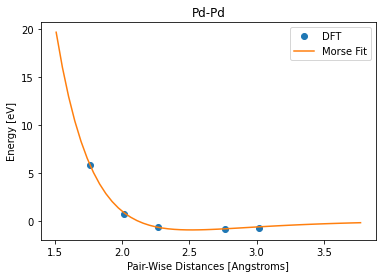

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:32:58    -8040.957161*       0.0700
BFGSLineSearch:    1[  1] 20:33:13    -8040.957494*       0.0210
BFGSLineSearch:    2[  2] 20:33:28    -8040.957529*       0.0005


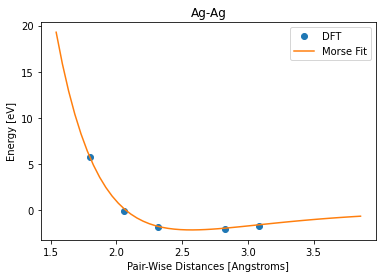

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:35:02    -3120.046073*       1.1854
BFGSLineSearch:    1[  1] 20:35:13    -3120.228938*       0.4546
BFGSLineSearch:    2[  3] 20:35:35    -3120.311412*       0.0102
BFGSLineSearch:    3[  6] 20:36:06    -3120.311509*       0.0001


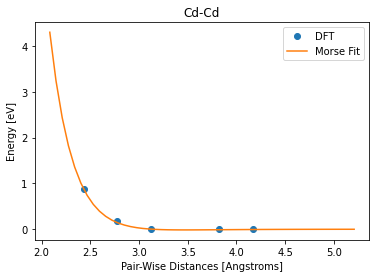

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:37:31    -3628.684327*       0.6579
BFGSLineSearch:    1[  2] 20:38:00    -3628.775552*       0.1347
BFGSLineSearch:    2[  3] 20:38:14    -3628.784711*       0.0619
BFGSLineSearch:    3[  4] 20:38:27    -3628.786884*       0.0122
BFGSLineSearch:    4[  5] 20:38:41    -3628.786928*       0.0010


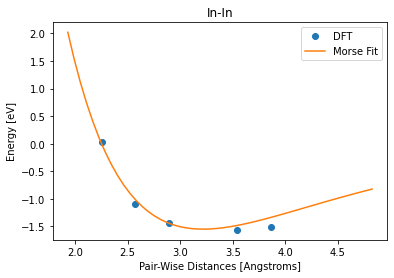

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 20:40:21    -4329.303077*       0.0950
BFGSLineSearch:    1[  1] 20:40:33    -4329.304167*       0.0111
BFGSLineSearch:    2[ 51] 20:48:12    -4329.304167*       0.0109
BFGSLineSearch:    3[ 97] 20:54:11    -4329.304167*       0.0107
BFGSLineSearch:    4[125] 20:57:35    -4329.304167*       0.0107
BFGSLineSearch:    5[195] 21:09:00    -4329.304167*       0.0106


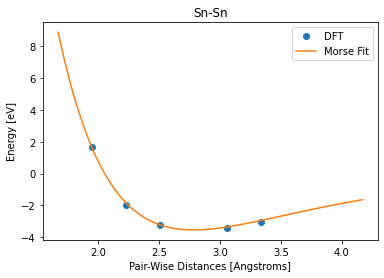

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:10:28    -5030.131688*       2.8746
BFGSLineSearch:    1[  2] 21:10:51    -5030.612664*       1.0003
BFGSLineSearch:    2[  4] 21:11:15    -5030.646674*       0.1185
BFGSLineSearch:    3[  5] 21:11:27    -5030.647003*       0.0165
BFGSLineSearch:    4[  6] 21:11:38    -5030.647021*       0.0003


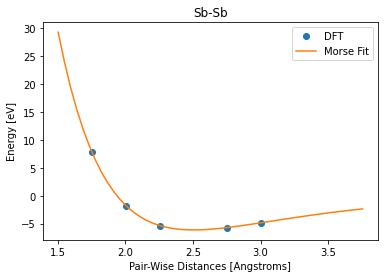

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:12:55     -719.333909*       1.3616
BFGSLineSearch:    1[  2] 21:13:15     -719.424540*       0.1086
BFGSLineSearch:    2[  3] 21:13:26     -719.424927*       0.0311
BFGSLineSearch:    3[  4] 21:13:37     -719.424962*       0.0005


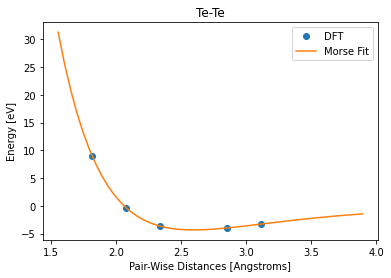

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:14:40    -1786.067146*       0.3036
BFGSLineSearch:    1[  2] 21:15:02    -1786.071138*       0.0004


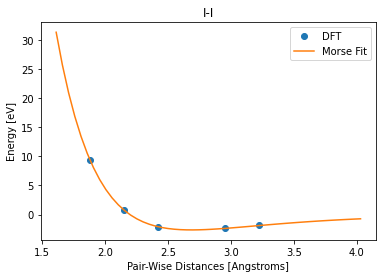

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:16:15    -1715.811733*       0.1722
BFGSLineSearch:    1[  3] 21:16:47    -1715.842056*       0.0079


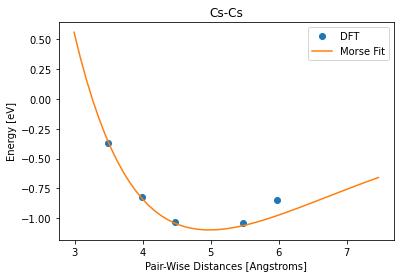

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:18:06    -1909.182011*       0.0463
BFGSLineSearch:    1[  4] 21:19:05    -1909.183879*       0.0027


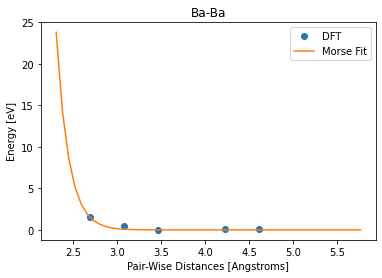

Unable to calculate element #57
Unable to calculate element #58
Unable to calculate element #59
Unable to calculate element #60
Unable to calculate element #61
Unable to calculate element #62
Unable to calculate element #63
Unable to calculate element #64
Unable to calculate element #65
Unable to calculate element #66
Unable to calculate element #67
Unable to calculate element #68
Unable to calculate element #69
Unable to calculate element #70
Unable to calculate element #71
                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:21:05    -4309.671229*       2.2125
BFGSLineSearch:    1[  1] 21:21:28    -4310.320797*       0.6491
BFGSLineSearch:    2[  3] 21:22:16    -4310.354678*       0.0421
BFGSLineSearch:    3[  4] 21:22:41    -4310.354856*       0.0003


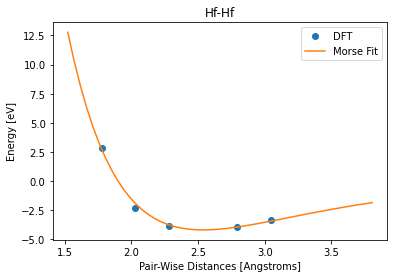

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:25:04    -3846.266634*       4.1647
BFGSLineSearch:    1[  2] 21:25:34    -3848.822182*       1.6438
BFGSLineSearch:    2[  4] 21:26:06    -3848.866248*       0.0522
BFGSLineSearch:    3[  5] 21:26:23    -3848.866296*       0.0075


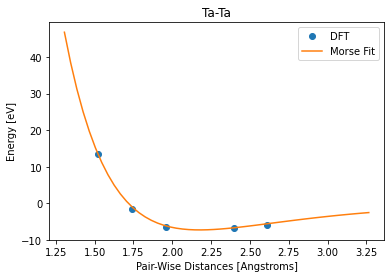

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:28:12    -4314.104251*       6.5653
BFGSLineSearch:    1[  4] 21:29:11    -4318.231957*       0.0029


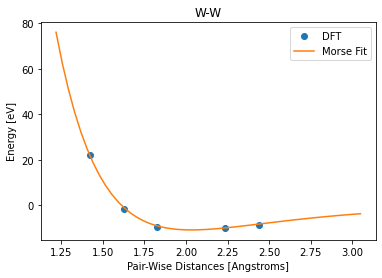

Unable to calculate element #75
Unable to calculate element #76
                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:31:09    -4935.331229*       3.9319
BFGSLineSearch:    1[  3] 21:32:02    -4935.953813*       0.0397
BFGSLineSearch:    2[  5] 21:32:40    -4935.953841*       0.0001


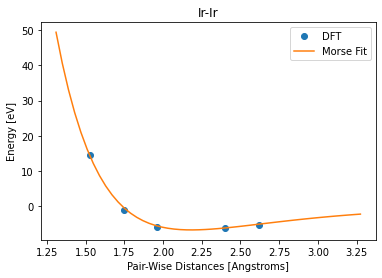

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:34:45    -5725.715421*       1.7564
BFGSLineSearch:    1[  2] 21:35:16    -5725.839267*       0.2795
BFGSLineSearch:    2[  3] 21:35:30    -5725.841130*       0.1110
BFGSLineSearch:    3[  4] 21:35:45    -5725.841464*       0.0030


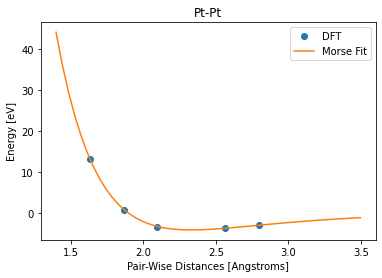

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 21:37:30    -3125.198647*       0.3931
BFGSLineSearch:    1[  2] 21:38:00    -3125.205530*       0.0371
BFGSLineSearch:    2[ 61] 21:49:14    -3125.205536*       0.0247
BFGSLineSearch:    3[120] 21:59:35    -3125.205536*       0.0247
BFGSLineSearch:    4[128] 22:01:33    -3125.205536*       0.0247
BFGSLineSearch:    5[194] 22:14:09    -3125.205536*       0.0236


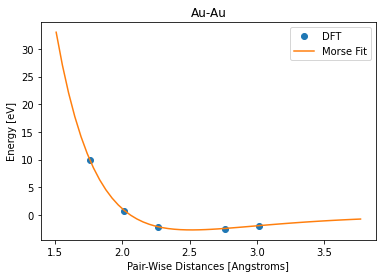

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 22:15:42    -2932.064956*       1.7733
BFGSLineSearch:    1[  1] 22:15:52    -2932.389381*       0.3844
BFGSLineSearch:    2[  3] 22:16:10    -2932.458199*       0.0197
BFGSLineSearch:    3[  6] 22:16:38    -2932.458732*       0.0051


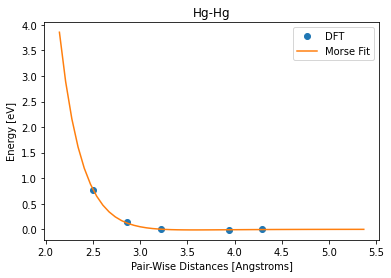

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 22:17:47    -3941.743510*       0.8898
BFGSLineSearch:    1[  2] 22:18:10    -3941.917171*       0.0738
BFGSLineSearch:    2[  5] 22:18:45    -3941.919845*       0.0024


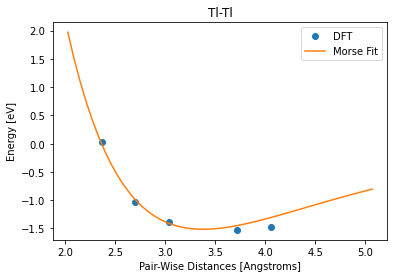

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 22:20:07    -4463.437215*       0.2748
BFGSLineSearch:    1[  1] 22:20:19    -4463.443142*       0.0527
BFGSLineSearch:    2[  2] 22:20:31    -4463.443283*       0.0082


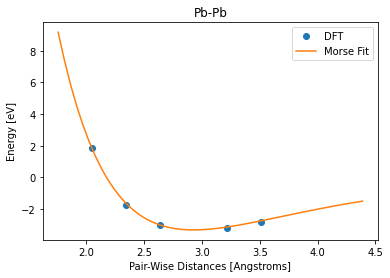

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 22:21:55    -5038.683503*       2.6798
BFGSLineSearch:    1[  1] 22:22:06    -5039.294106*       0.5100
BFGSLineSearch:    2[  3] 22:22:29    -5039.302329*       0.0129
BFGSLineSearch:    3[ 33] 22:27:07    -5039.302330*       0.0061


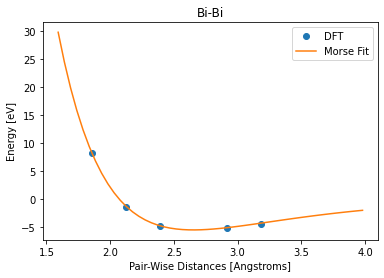

In [ ]:
os.makedirs('./morse_params', exist_ok=True)
for i in range(29,84):
  if i not in [2,10,18,36,54]:
    try:
      bond_calcs(i)
    except Exception:
      print(f'Unable to calculate element #{i}')
    os.system('rm -rf qe_*')